In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images


Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
  0% 0.00/98.7M [00:00<?, ?B/s]
100% 98.7M/98.7M [00:00<00:00, 1.77GB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/melanoma-skin-cancer-dataset-of-10000-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [7]:
import tensorflow as tf, numpy as np, pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [8]:
train_path = '/content/melanoma_cancer_dataset/train'
ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size = (256, 256),
    shuffle =True,
)


Found 9605 files belonging to 2 classes.


In [9]:
test_path = '/content/melanoma_cancer_dataset/test'
test= keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size= (256, 256),
    shuffle = True,
)

Found 1000 files belonging to 2 classes.


In [10]:
#splitting datasets
DATASET_SIZE= len(ds)
TRAIN_RATIO, VALIDATION_RATIO = 0.8, 0.2
train = ds.take(int(DATASET_SIZE*TRAIN_RATIO))
val  = ds.skip(int(DATASET_SIZE*TRAIN_RATIO))

print(len(train), len(val))

240 61


In [11]:
import matplotlib.pyplot as plt

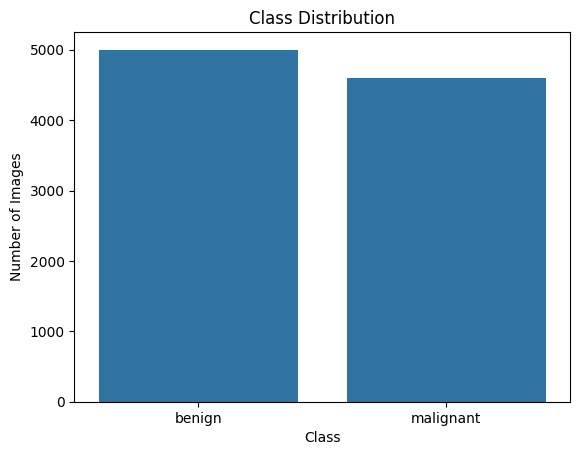

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

labels = []
for _, label_batch in ds:
    labels.extend(label_batch.numpy())

plt.figure()
sns.countplot(x=labels)
plt.xticks([0,1], ds.class_names)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

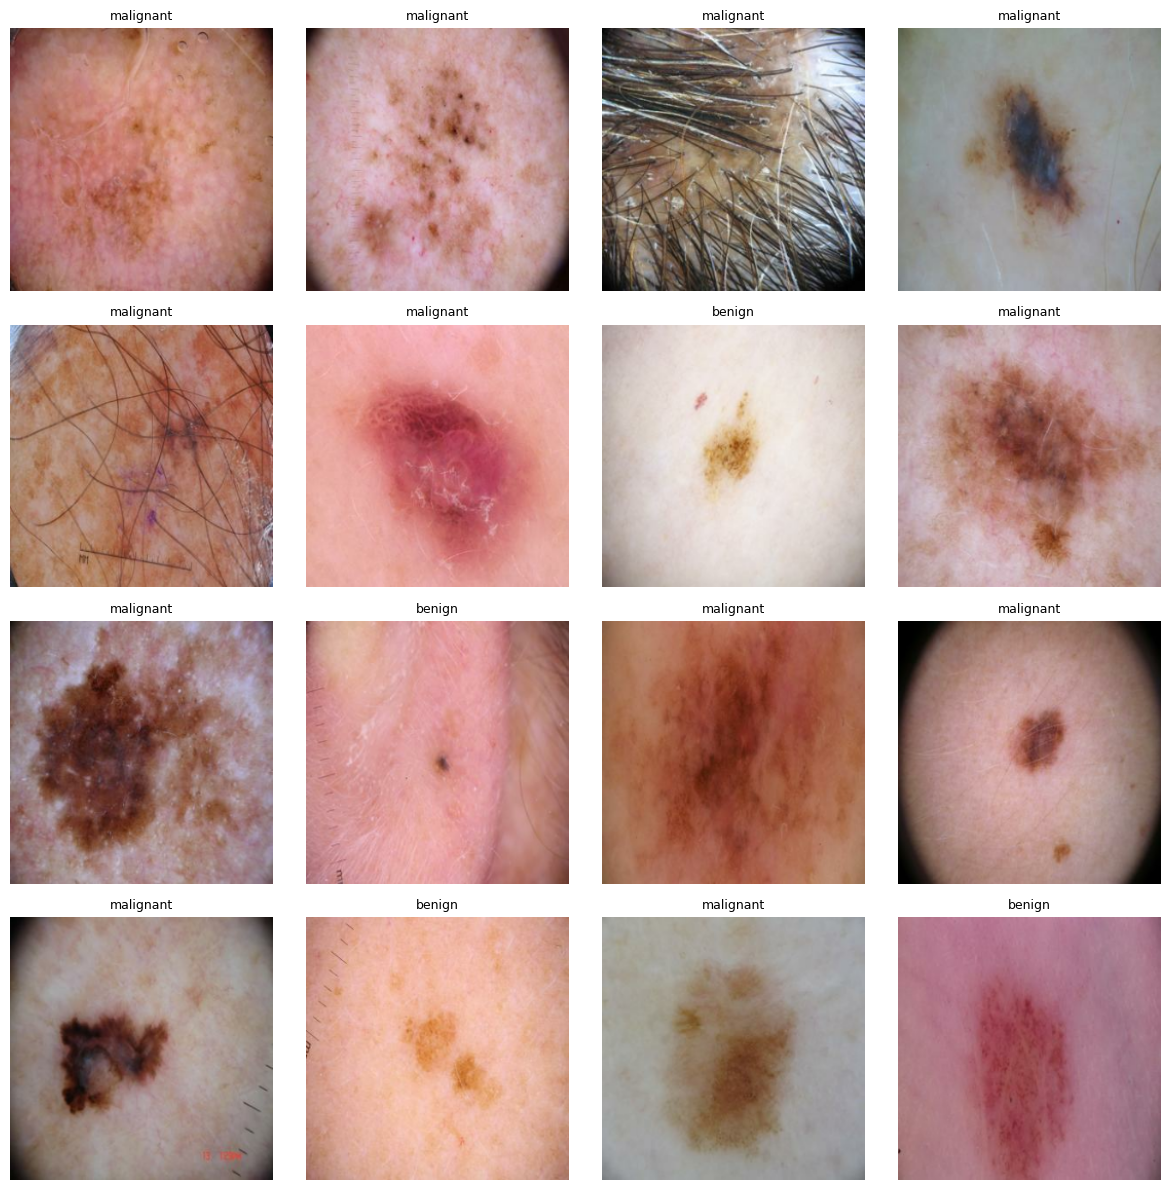

In [22]:
class_names = ds.class_names

plt.figure(figsize=(12, 12))

for image_batch, label_batch in ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]], fontsize=9)
        plt.axis("off")

plt.tight_layout()
plt.show()

In [14]:
from tensorflow.keras import layers, models
import tensorflow as tf

data_augmentation = models.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train = train.map(normalize_image).prefetch(AUTOTUNE)
val   = val.map(normalize_image).prefetch(AUTOTUNE)
test  = test.map(normalize_image).prefetch(AUTOTUNE)

In [16]:
model = models.Sequential()

# Augmentation Layer
model.add(data_augmentation)

# Block 1
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 2
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 3
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 4
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Classification Head
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

In [17]:
model.build((None, 256, 256, 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,754 (1.64 MB)

 Trainable params: 430,498 (1.64 MB)

 Non-trainable params: 256 (1.00 KB)

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [21]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1
)

In [23]:
history = model.fit(
    train,
    validation_data=val,
    epochs=30,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 45s 150ms/step - accuracy: 0.8079 - loss: 0.7060 - val_accuracy: 0.6551 - val_loss: 0.6412 - learning_rate: 0.0010
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 76s 150ms/step - accuracy: 0.8564 - loss: 0.3715 - val_accuracy: 0.8519 - val_loss: 0.3480 - learning_rate: 0.0010
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 36s 149ms/step - accuracy: 0.8745 - loss: 0.3097 - val_accuracy: 0.6888 - val_loss: 0.8284 - learning_rate: 0.0010
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8849 - loss: 0.2804
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
240/240 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.8849 - loss: 0.2805 - val_accuracy: 0.7657 - val_loss: 0.5768 - learning_rate: 0.0010
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 36s 149ms/step - accuracy: 0.8915 - loss: 0.2589 - val_accuracy: 0.8571 - val_loss: 0.3145 - learning_rate: 3.0000e-04
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - accuracy: 0

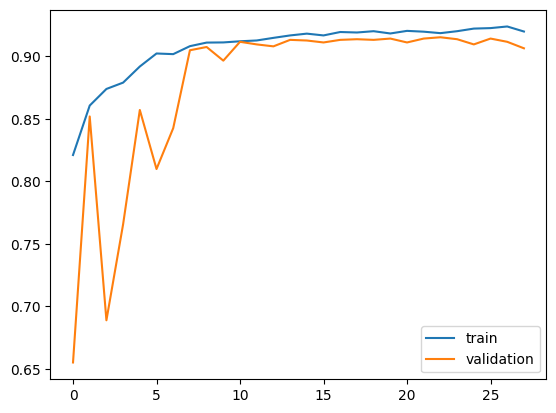

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9177 - loss: 0.2248
0.2216191291809082 0.9190000295639038
Actual Label:  malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Predicted Label:  malignant


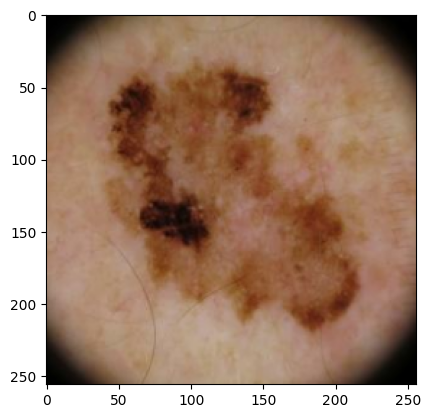

In [25]:
# MODEL EVALUATION

loss, accuracy = model.evaluate(test); print(loss, accuracy)

for images, label in test.take(1):
    img = (images[0]*255).numpy().astype('uint8')
    plt.imshow(img)
    print('Actual Label: ', class_names[label[0].numpy()])
    pred = model.predict(images)
    print('Predicted Label: ', class_names[np.argmax(pred[0])])

In [28]:
model.save('model.h5')

Actual Label:  malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Label:  malignant


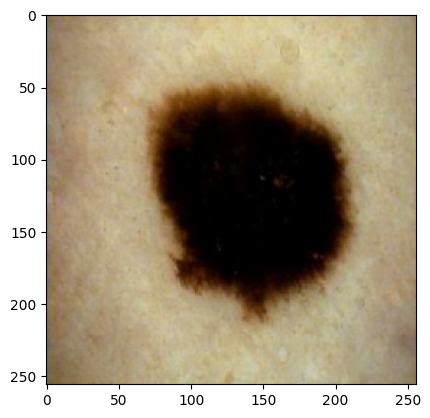

In [26]:
for images, label in test.take(1):
    img = (images[0]*255).numpy().astype('uint8')
    plt.imshow(img)
    print('Actual Label: ', class_names[label[0].numpy()])
    pred = model.predict(images)
    print('Predicted Label: ', class_names[np.argmax(pred[0])])

In [31]:
model.save('skin_cancer_model.h5')

In [27]:
model.save('model.h5')

In [29]:
#MATRIX & PERFORMANCE EVALUATION
true, predicted = [], []
for images, labels in test:
    for img, label in zip(images, labels):
        true.append(label.numpy())
        pred = model.predict(tf.expand_dims(img, axis=0))
        predicted.append(np.argmax(pred[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

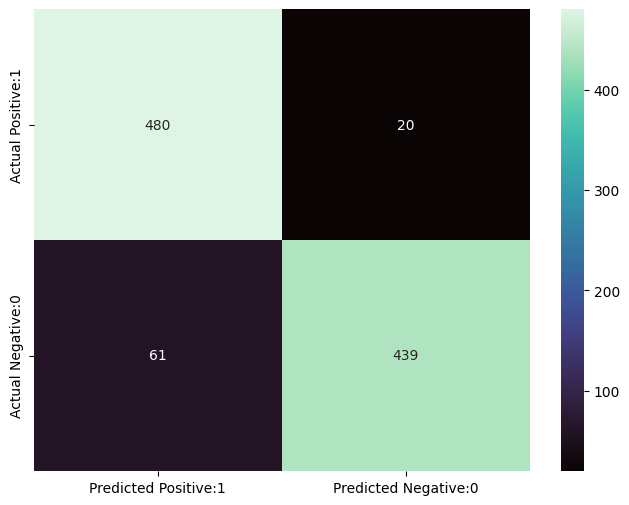


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       500
           1       0.96      0.88      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

true, predicted = [], []
for images, labels in test:
    for img, label in zip(images, labels):
        true.append(label.numpy())
        pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)
        predicted.append(np.argmax(pred[0]))

cm = confusion_matrix(true, predicted)
cm_matrix = pd.DataFrame(
    data=cm,
    columns=['Predicted Positive:1', 'Predicted Negative:0'],
    index=['Actual Positive:1', 'Actual Negative:0']
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')
plt.show()

print("\nClassification Report:")
print(classification_report(true, predicted))